# Prepare Dataset


In [1]:
import os
import re

import pandas as pd
from bs4 import BeautifulSoup

In [2]:
df = pd.read_csv(
    "./input/deceptive-opinion-spam-corpus/deceptive-opinion.csv"
)

In [3]:
df = df.drop(["hotel", "polarity", "source"], axis=1)

In [4]:
df.head()

,deceptive,text
0,truthful,We stayed for a one night getaway with family ...
1,truthful,Triple A rate with upgrade to view room was le...
2,truthful,This comes a little late as I'm finally catchi...
3,truthful,The Omni Chicago really delivers on all fronts...
4,truthful,I asked for a high floor away from the elevato...


In [5]:
df1 = df.sample(frac=1)

In [6]:
df1.head()

,deceptive,text
571,deceptive,The Affinia Hotel is beautiful! It's in a grea...
786,deceptive,The Palmer House Hilton in Chicago is by far t...
1550,deceptive,I was highly disappointed with my choice to st...
1232,deceptive,"The Conrad Chicago is a Michelin rated hotel, ..."
112,truthful,The Swisshotel is awesome. Very high class. It...


In [7]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df1["deceptive"] = label_encoder.fit_transform(df1["deceptive"])

df1["deceptive"].unique()

array([0, 1])

In [8]:
df1.head()

,deceptive,text
571,0,The Affinia Hotel is beautiful! It's in a grea...
786,0,The Palmer House Hilton in Chicago is by far t...
1550,0,I was highly disappointed with my choice to st...
1232,0,"The Conrad Chicago is a Michelin rated hotel, ..."
112,1,The Swisshotel is awesome. Very high class. It...


In [9]:
df1.describe()

,deceptive
count,1600.000000
mean,0.500000
std,0.500156
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


## Data cleaning


In [10]:
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;]")
BAD_SYMBOLS_RE = re.compile("[^0-9a-z #+_]")
STOPWORDS = set(stopwords.words("english"))


def clean_data(text):
    """
    text: a string

    return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text  # HTML decoding
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text


df1["text"] = df1["text"].apply(clean_data)

C:\Users\james\AppData\Local\Temp\ipykernel_30080\3487305283.py:14: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text  # HTML decoding


In [11]:
X = df1.text
y = df1.deceptive

In [12]:
X = X.map(lambda a: clean_data(a))

In [13]:
from __future__ import print_function

import numpy as np
from keras import constraints, initializers, regularizers
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [14]:
# X_train, y_train for training (70%)
# X_val, y_val for development (15%)
# X_test, y_test for testing (15%)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% dev, 15% test

# train, test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [15]:
tokenizer = Tokenizer(
    num_words=None,
    lower=True,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    split=" ",
    char_level=False,
)

In [16]:
tokenizer.fit_on_texts(X)

In [17]:
x_train = tokenizer.texts_to_sequences(X_train)
x_val = tokenizer.texts_to_sequences(X_val)
x_test = tokenizer.texts_to_sequences(X_test)

In [18]:
word_index = tokenizer.word_index

In [19]:
X = tokenizer.texts_to_sequences(X)

In [20]:
vocab_size = len(word_index)
print("Vocab size: {}".format(vocab_size))
longest = max(len(seq) for seq in X)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in X])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in X])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print("Max comment size: {}".format(max_len))

Vocab size: 9635
Longest comment size: 795
Average comment size: 150.44875
Stdev of comment size: 88.50470254985042
Max comment size: 415


## Padding


In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [22]:
processed_post_x_train = pad_sequences(
    x_train, maxlen=max_len, padding="post", truncating="post"
)
processed_post_x_val = pad_sequences(
    x_val, maxlen=max_len, padding="post", truncating="post"
)
processed_post_x_test = pad_sequences(
    x_test, maxlen=max_len, padding="post", truncating="post"
)

In [23]:
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_val = pad_sequences(x_val, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)

In [24]:
processed_pre_x_train = pad_sequences(x_train, maxlen=max_len)
processed_pre_x_val = pad_sequences(x_val, maxlen=max_len)
processed_pre_x_test = pad_sequences(x_test, maxlen=max_len)

In [25]:
print("x_train shape:", processed_x_train.shape)
print("x_val shape:", processed_x_val.shape)

x_train shape: (1120, 415)
x_val shape: (240, 415)


# Model


In [26]:
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import (
    LSTM,
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    CuDNNGRU,
    Dense,
    Dropout,
    Embedding,
    GlobalMaxPooling1D,
    Input,
    MaxPooling1D,
    concatenate,
)
from keras.models import Model, Sequential, load_model
from keras.optimizers import Nadam
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import AdditiveAttention, Embedding, Layer, concatenate

In [27]:
embeddings_index = {}
f = open(
    os.path.join(
        "./input/glove-global-vectors-for-word-representation", "glove.6B.100d.txt"
    )
)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [28]:
embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

In [29]:
class Attention(Layer):
    def __init__(
        self,
        step_dim,
        W_regularizer=None,
        b_regularizer=None,
        W_constraint=None,
        b_constraint=None,
        bias=True,
        **kwargs
    ):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        # self.init = initializations.get('glorot_uniform')
        self.init = initializers.get("glorot_uniform")

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        # self.W = self.add_weight((input_shape[-1],),
        #                          initializer=self.init,
        #                          name='{}_W'.format(self.name),
        #                          regularizer=self.W_regularizer,
        #                          constraint=self.W_constraint)

        self.W = self.add_weight(
            shape=(input_shape[-1],),
            initializer=self.init,  # ensure `init` is set up as a valid initializer
            name="W",
            regularizer=self.W_regularizer,
            constraint=self.W_constraint,
        )

        self.features_dim = input_shape[-1]

        if self.bias:
            # self.b = self.add_weight((input_shape[1],),
            #                          initializer='zero',
            #                           name='{}_b'.format(self.name),
            #                          regularizer=self.b_regularizer,
            #                          constraint=self.b_constraint)
            self.b = self.add_weight(
                shape=(input_shape[1],),
                initializer=initializers.get(
                    "zeros"
                ),  # make sure `self.init` is a valid initializer
                name="b",  # only one `name` argument
                regularizer=self.b_regularizer,
                constraint=self.b_constraint,
            )

        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(
            K.dot(
                K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))
            ),
            (-1, step_dim),
        )

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        # print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        # return input_shape[0], input_shape[-1]
        return input_shape[0], self.features_dim

    def get_config(self):
        # Convert regularizers and constraints to their config forms
        config = super(Attention, self).get_config()
        config.update(
            {
                "step_dim": self.step_dim,
                "W_regularizer": (
                    self.W_regularizer.get_config() if self.W_regularizer else None
                ),
                "b_regularizer": (
                    self.b_regularizer.get_config() if self.b_regularizer else None
                ),
                "W_constraint": (
                    self.W_constraint.get_config() if self.W_constraint else None
                ),
                "b_constraint": (
                    self.b_constraint.get_config() if self.b_constraint else None
                ),
                "bias": self.bias,
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        # Re-create the regularizers and constraints from their config forms
        config["W_regularizer"] = regularizers.get(config["W_regularizer"])
        config["b_regularizer"] = regularizers.get(config["b_regularizer"])
        config["W_constraint"] = constraints.get(config["W_constraint"])
        config["b_constraint"] = constraints.get(config["b_constraint"])
        return cls(**config)

In [30]:
def get_model():
    review_input = Input(shape=(max_len,), dtype="int32")
    review_input_post = Input(shape=(max_len,), dtype="int32")

    # Use review_input here
    x1 = Embedding(
        vocab_size + 1,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
    )(review_input)
    x1 = Bidirectional(LSTM(60, return_sequences=True))(x1)
    x1 = Dropout(0.3)(x1)  # original = 0.3
    x1 = Attention(max_len)(x1)

    # Use review_input_post here
    x2 = Embedding(
        vocab_size + 1,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
    )(review_input_post)
    x2 = Bidirectional(LSTM(60, return_sequences=True))(x2)
    x2 = Dropout(0.3)(x2)  # original = 0.3
    x2 = Attention(max_len)(x2)

    x = concatenate([x1, x2])
    x = Dense(50, activation="relu")(x)
    x = Dropout(0.2)(x)  # original = 0.2
    x = BatchNormalization()(x)
    preds = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=[review_input, review_input_post], outputs=preds)

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

In [31]:
model = get_model()

In [32]:
# from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, Concatenate, AdditiveAttention
# from tensorflow.keras.models import Model


# def get_model():
#     # Define input layers
#     review_input = Input(shape=(max_len,), dtype='int32')
#     review_input_post = Input(shape=(max_len,), dtype='int32')

#     # Embedding and LSTM layers for the first input
#     x1 = Embedding(vocab_size + 1, embedding_dim,
#                    weights=[embedding_matrix], input_length=max_len, trainable=True)(review_input)
#     x1 = Bidirectional(LSTM(60, return_sequences=True))(x1)
#     x1 = Dropout(0.3)(x1)

#     # Embedding and LSTM layers for the second input
#     x2 = Embedding(vocab_size + 1, embedding_dim, weights=[
#                    embedding_matrix], input_length=max_len, trainable=True)(review_input_post)
#     x2 = Bidirectional(LSTM(60, return_sequences=True))(x2)
#     x2 = Dropout(0.3)(x2)

#     # Additive Attention layers for each input (using self-attention)
#     attention_layer_1 = AdditiveAttention()
#     # query and key-value pairs are the same for self-attention
#     x1 = attention_layer_1([x1, x1])

#     attention_layer_2 = AdditiveAttention()
#     # query and key-value pairs are the same for self-attention
#     x2 = attention_layer_2([x2, x2])

#     # Concatenate the outputs of both attention layers
#     x = Concatenate()([x1, x2])

#     # Dense layers
#     x = Dense(50, activation='relu')(x)
#     x = Dropout(0.2)(x)
#     x = BatchNormalization()(x)

#     # Output layer
#     preds = Dense(1, activation='sigmoid')(x)

#     # Build the model
#     model = Model(inputs=[review_input, review_input_post], outputs=preds)

#     # Compile the model
#     model.compile(loss='binary_crossentropy',
#                   optimizer='adam', metrics=['accuracy'])

#     return model

In [33]:
# model = get_model()

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 415)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 415)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 415, 100)     963600      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 415, 100)     963600      ['input_2[0][0]']                
                                                                                              

# Train


In [35]:
from keras.callbacks import ModelCheckpoint

In [36]:
# checkpoint
filepath = "./results/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"
)
callbacks_list = [checkpoint]

In [37]:
from keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=10)

In [38]:
want_load = False
model_checkpoint = "./results/weights-improvement-12-0.88.hdf5"

if want_load:
    model = get_model()
    model.load_weights(model_checkpoint)

In [39]:
history = model.fit(
    [processed_x_train, processed_pre_x_train],
    y_train,
    validation_data=([processed_x_val, processed_pre_x_val], y_val),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping_monitor, checkpoint],
    verbose=1,
)

Epoch 1/15
18/18 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.5652
Epoch 1: val_accuracy improved from -inf to 0.55833, saving model to ./results\weights-improvement-01-0.56.hdf5
18/18 [==============================] - 33s 2s/step - loss: 0.6921 - accuracy: 0.5652 - val_loss: 0.6833 - val_accuracy: 0.5583
Epoch 2/15
18/18 [==============================] - ETA: 0s - loss: 0.5747 - accuracy: 0.7107
Epoch 2: val_accuracy improved from 0.55833 to 0.69167, saving model to ./results\weights-improvement-02-0.69.hdf5
18/18 [==============================] - 26s 1s/step - loss: 0.5747 - accuracy: 0.7107 - val_loss: 0.6662 - val_accuracy: 0.6917
Epoch 3/15
18/18 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.7902
Epoch 3: val_accuracy improved from 0.69167 to 0.77500, saving model to ./results\weights-improvement-03-0.77.hdf5
18/18 [==============================] - 25s 1s/step - loss: 0.4570 - accuracy: 0.7902 - val_loss: 0.6004 - val_accura

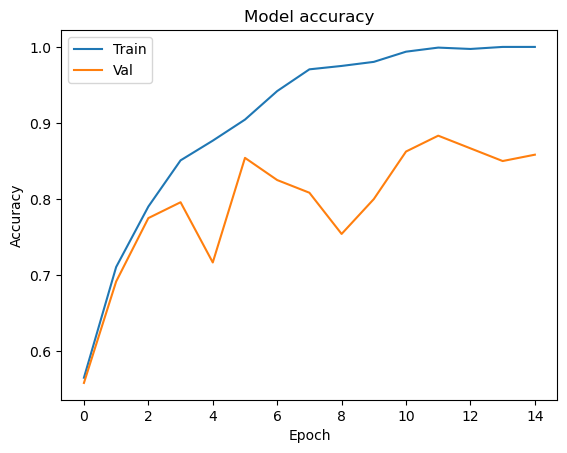

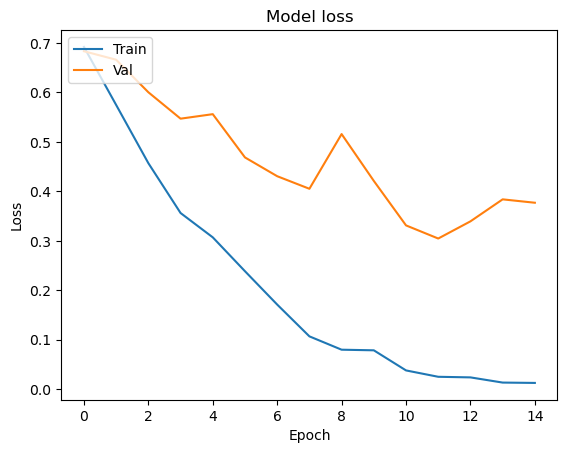

In [40]:
# Plot training & validation accuracy values
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

# Plot training & validation loss values
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

# Evaluation


In [41]:
results = model.evaluate([processed_x_test, processed_pre_x_test], y_test)

8/8 [==============================] - 3s 336ms/step - loss: 0.3880 - accuracy: 0.8500


In [42]:
print("test loss: ", results[0])
print("test acc:  ", results[1])

test loss:  0.3879595398902893
test acc:   0.8500000238418579


In [43]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])